In [1]:
# Import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D

Using TensorFlow backend.


In [2]:
# Data
df = pd.read_csv('GBPJPY_50.csv', delimiter=",").iloc[:, 1].values
# Short Moving Average
window = 100
med = np.array([ np.mean(df[i-window:i+1]) for i in range(window, len(df))])
# Long Exponentially Weightned Average
window2 = 750
med2 = np.array([ np.mean(df[i-window2:i+1]) for i in range(window2, len(df))])

In [3]:
print(df.shape, med.shape, med2.shape)

(360696,) (360596,) (359946,)


In [4]:
# If distance between two medians is less than treshold: cross point
treshold = 0.005
points = np.array([ 0 if abs(med[window2-window+i]-med2[i]) > treshold else 1 for i in range(len(df)-window2)])
x_coord = np.array([i for i,point in enumerate(points[:10000]) if point == 1])
y_coord = np.array([med2[i] for i in x_coord])
x_coord = np.array([i+window2 for i in x_coord])

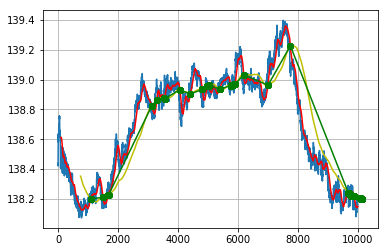

In [5]:
# Initial plot to visualize data
max_plot = min(10000, len(df))

plt.figure()
plt.plot(df[:max_plot])
plt.plot(np.arange(window, max_plot), med[:max_plot-window], 'r')
plt.plot(np.arange(window2, max_plot), med2[:max_plot-window2], 'y')
plt.plot(x_coord, y_coord, '-og')
plt.grid()
plt.show()

In [6]:
# Create labels
predict_window = 75
y_labeled = np.array([ 1 if points[i:i+predict_window].any() == 1 else 0 for i in range(len(points)-predict_window)])

In [7]:
x_data = pd.DataFrame({'prices': df[window2:len(df)-predict_window],
                       'med_s': med[window2-window:len(med)-predict_window]-df[window2:len(df)-predict_window],
                       'med_h': med2[:len(med2)-predict_window]-med[window2-window:len(med)-predict_window]}).as_matrix()[:50000]
win_input = 444

In [8]:
x_data = np.array([x_data[i-win_input:i] for i in range(win_input, len(x_data))])
y_labels = y_labeled[win_input:50000]
print(x_data.shape, y_labels.shape)

(49556, 444, 3) (49556,)


In [9]:
# Model Params
kernel_size,filters = 4,3
pooling = 2
shape_0, shape_1 = x_data.shape[1],x_data.shape[2]

In [10]:
# Create the model
model = Sequential((
    # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
    # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
    # the input timeseries, the activation of each filter at that position.
    Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear', input_shape=(shape_0, shape_1)),
    MaxPooling1D(pool_size = 3),     # Downsample the output of convolution by 2X.
    Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear'),
    MaxPooling1D(pool_size = 3),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear'),
    MaxPooling1D(pool_size = 3),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear'),
    MaxPooling1D(pool_size = 3),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='linear'),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(256, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [11]:
his = model.fit(x_data, y_labels, epochs=5, batch_size=64, verbose=1, validation_split=0.1, shuffle=True)

Train on 44600 samples, validate on 4956 samples
Epoch 1/5
44600/44600 [==============================] - 10s - loss: 0.2347 - binary_accuracy: 0.8899 - val_loss: 0.3178 - val_binary_accuracy: 0.8404
Epoch 2/5
44600/44600 [==============================] - 9s - loss: 0.2275 - binary_accuracy: 0.8941 - val_loss: 0.4366 - val_binary_accuracy: 0.7847
Epoch 3/5
44600/44600 [==============================] - 9s - loss: 0.2193 - binary_accuracy: 0.8975 - val_loss: 0.4410 - val_binary_accuracy: 0.8075
Epoch 4/5
44600/44600 [==============================] - 9s - loss: 0.2165 - binary_accuracy: 0.9006 - val_loss: 0.4591 - val_binary_accuracy: 0.7972
Epoch 5/5
44600/44600 [==============================] - 9s - loss: 0.2233 - binary_accuracy: 0.8958 - val_loss: 0.4267 - val_binary_accuracy: 0.8105


In [12]:
x_data = pd.DataFrame({'prices': df[window2:len(df)-predict_window],
                       'med_s': med[window2-window:len(med)-predict_window]-df[window2:len(df)-predict_window],
                       'med_h': med2[:len(med2)-predict_window]-med[window2-window:len(med)-predict_window]}).as_matrix()[55000:60000]
x_test = np.array([x_data[i-win_input:i] for i in range(win_input, len(x_data))])
# Make predictions on unseen data
predicts = model.predict(x_test)[:-(window2)]

<IPython.core.display.Javascript object>


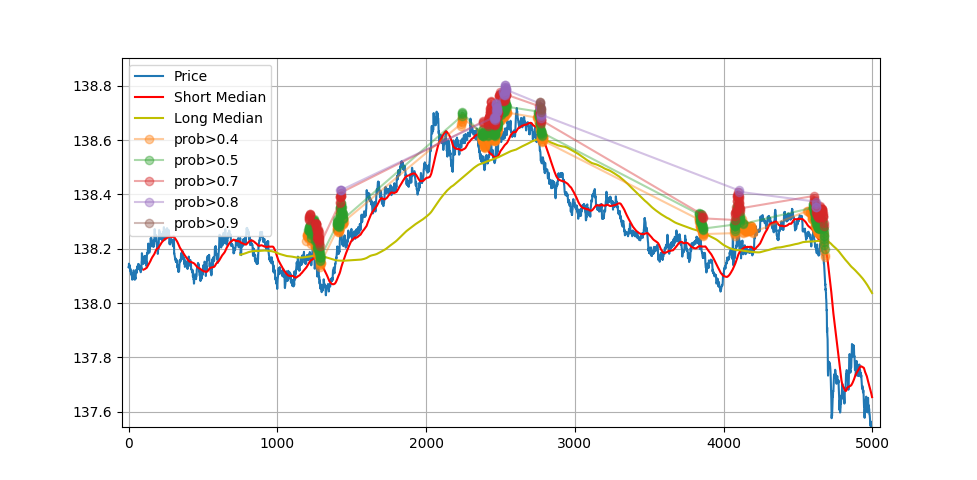

0.4 : 579
0.5 : 435
0.7 : 248
0.8 : 58
0.9 : 7


In [13]:
%matplotlib notebook
# Plot results
batch, max_plot = 55000,5000
plt.figure()
plt.plot(df[batch:batch+max_plot])
plt.plot(np.arange(window, max_plot), med[batch:batch+max_plot-window], 'r')
plt.plot(np.arange(window2, max_plot), med2[batch:batch+max_plot-window2], 'y')

for prob in [.4, .5, .7, .8, .9]:
    # Catch points above certain prob
    x_coord = np.array([i for i,pred in enumerate(predicts) if pred >= prob])
    y_coord = np.array([df[batch+window2+win_input+x]+0.2*prob for x in x_coord])
    x_coord = np.array([x+window2+win_input for x in x_coord ])
    print(prob, ":", len(x_coord))
    plt.plot(x_coord, y_coord, '-o', alpha =0.4)
    
# Plot graph
plt.legend(['Price', 'Short Median', 'Long Median',
           'prob>0.4', 'prob>0.5', 'prob>0.7', 'prob>0.8',
           'prob>0.9'], loc='upper left')
plt.grid()  
plt.show()

<IPython.core.display.Javascript object>


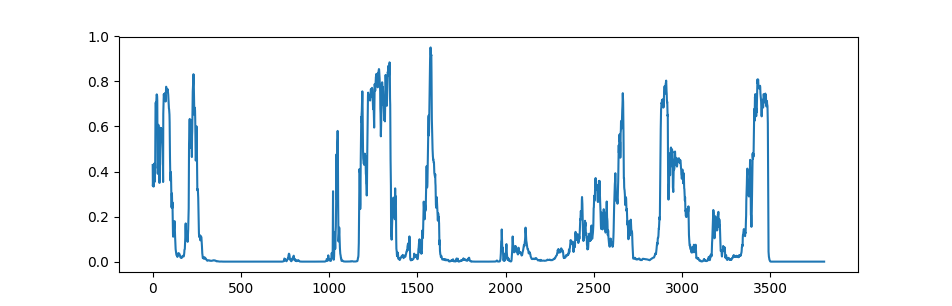

In [14]:
plt.figure()
plt.plot(predicts)
plt.show()